# INSIGHTS


Usando a Regressão linear simples notei que há um resultado razoavel quanto ao vies.

Usando a Random Forest notei que o R2 é inferior ao da RL, e há uma varincia maior e em vários momentos os valores são muito proximos ao valor real.

De modo geral avaliando o timeframe D1 o modelo de regressão esta se demonstrando favoravel a questão de indicar a direção do mercado.

Utilizando o exemplo do Andre (tera) há uma expectativa de melhoria uma vez que ele utilizou boas features (LTA/LTB, Suporte e resistencia, Média, Bollinger e RSI). O modelo em questão foi colocado em produção com uma acurácia de 75%.

<b>Alertas!</b><p>
quando o Close for igual ao Open ....deixar um feedback de DOJI<p>
para plotagem ou modelagem considerar o o drop_duplicates(subset=time, keep='last')

# PROBLEMAS

### Bibliotecas

In [2]:
import pandas as pd
import numpy as np

from scipy.stats.mstats import gmean,hmean
from statistics import harmonic_mean, geometric_mean


import warnings
warnings.filterwarnings("ignore")
#plt.rcParams['figure.figsize'] = (18,8)


# bibliotecas para tratamento dos dados
from datetime import datetime, timedelta
from tqdm import tqdm
import time
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# bibliotecas de visualização
import matplotlib.pyplot as plt
import seaborn as sns

# indicadores traders
from talib import RSI, BBANDS

import talib

#import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# biblioteca modelo
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

In [3]:
# EURUSD - 17/03/2023 - fonte: https://forexsoftware.com.br/historical-forex-data
colunas = ['time', 'open', 'high', 'low', 'close', 'volume']
df = pd.read_csv(r'C:\_PY\Trade_NB\_DS\Bases\EURUSD_M1.csv')
df.columns = colunas
df['from'] = df.time
df.index = df.time

# CLASSIFICAÇÃO

In [ ]:
df['amplitude'] = df['high'] - df['low']
df['body'] = np.where(df["close"] > df["open"], df["close"] - df["open"], df["open"] - df["close"])
df['pavil'] = df['amplitude'] - df['body']
df['pavil_call'] = np.where(df["close"] > df["open"], df['high'] - df['close'], df['high'] - df['open'])
df['pavil_put'] = np.where(df["close"] > df["open"], df['open'] - df['low'], df['close'] - df['low'])
df["retorno_volume"] = df["volume"].pct_change(1)*100
df["retorno"] = df["close"].pct_change(1)*100

In [87]:
df['amplitude'] = df['high'] - df['low']

In [88]:
df['body'] = np.where(df["close"] > df["open"], df["close"] - df["open"], df["open"] - df["close"])

In [89]:
df['pavil'] = df['amplitude'] - df['body']

In [90]:
df['pavil_call'] = np.where(df["close"] > df["open"], df['high'] - df['close'], df['high'] - df['open'])
df['pavil_put'] = np.where(df["close"] > df["open"], df['open'] - df['low'], df['close'] - df['low'])

In [91]:
df["retorno_volume"] = df["volume"].pct_change(1)*100

In [92]:
df["retorno"] = df["close"].pct_change(1)*100

In [93]:
df["alvo1"] = df["retorno"].shift(-1)

In [98]:
# Target = Call 1 / Put 0
df['target'] = np.where(df["close"] > df["open"], 1,0)
df['target_alvo1'] = np.where(df["alvo1"] > 0, 1,0)

In [99]:
df = df.dropna()

In [100]:
df.columns

Index(['time', 'open', 'high', 'low', 'close', 'volume', 'from', 'amplitude',
       'body', 'pavil', 'pavil_call', 'pavil_put', 'retorno_volume', 'retorno',
       'alvo1', 'target', 'target_alvo1'],
      dtype='object')

In [101]:
df

time     open     high      low    close  \
time                                                                     
2022-12-09 14:21  2022-12-09 14:21  1.05581  1.05588  1.05567  1.05567   
2022-12-09 14:22  2022-12-09 14:22  1.05568  1.05589  1.05566  1.05584   
2022-12-09 14:23  2022-12-09 14:23  1.05585  1.05588  1.05563  1.05565   
2022-12-09 14:24  2022-12-09 14:24  1.05564  1.05574  1.05541  1.05544   
2022-12-09 14:25  2022-12-09 14:25  1.05545  1.05580  1.05545  1.05579   
...                            ...      ...      ...      ...      ...   
2023-03-17 11:54  2023-03-17 11:54  1.06422  1.06425  1.06404  1.06406   
2023-03-17 11:55  2023-03-17 11:55  1.06408  1.06416  1.06400  1.06406   
2023-03-17 11:56  2023-03-17 11:56  1.06406  1.06441  1.06403  1.06439   
2023-03-17 11:57  2023-03-17 11:57  1.06438  1.06461  1.06437  1.06457   
2023-03-17 11:58  2023-03-17 11:58  1.06457  1.06483  1.06457  1.06464   

                  volume              from  amplitude     body    pavil  \
time                                                                      
2022-12-09 14:21     273  2022-12-09 14:21    0.00021  0.00014  0.00007   
2022-12-09 14:22     193  2022-12-09 14:22    0.00023  0.00016  0.00007   
2022-12-09 14:23     326  2022-12-09 14:23    0.00025  0.00020  0.00005   
2022-12-09 14:24     188  2022-12-09 14:24    0.00033  0.00020  0.00013   
2022-12-09 14:25     340  2022-12-09 14:25    0.00035  0.00034  0.00001   
...                  ...               ...        ...      ...      ...   
2023-03-17 11:54     521  2023-03-17 11:54    0.00021  0.00016  0.00005   
2023-03-17 11:55     394  2023-03-17 11:55    0.00016  0.00002  0.00014   
2023-03-17 11:56     491  2023-03-17 11:56    0.00038  0.00033  0.00005   
2023-03-17 11:57     314  2023-03-17 11:57    0.00024  0.00019  0.00005   
2023-03-17 11:58     364  2023-03-17 11:58    0.00026  0.00007  0.00019   

                  pavil_call  pavil_put  retorno_volume   retorno     alvo1  \
time                                                                          
2022-12-09 14:21     0.00007    0.00000      -19.705882 -0.014207  0.016104   
2022-12-09 14:22     0.00005    0.00002      -29.304029  0.016104 -0.017995   
2022-12-09 14:23     0.00003    0.00002       68.911917 -0.017995 -0.019893   
2022-12-09 14:24     0.00010    0.00003      -42.331288 -0.019893  0.033162   
2022-12-09 14:25     0.00001    0.00000       80.851064  0.033162  0.005683   
...                      ...        ...             ...       ...       ...   
2023-03-17 11:54     0.00003    0.00002       29.280397 -0.014095  0.000000   
2023-03-17 11:55     0.00008    0.00006      -24.376200  0.000000  0.031013   
2023-03-17 11:56     0.00002    0.00003       24.619289  0.031013  0.016911   
2023-03-17 11:57     0.00004    0.00001      -36.048880  0.016911  0.006575   
2023-03-17 11:58     0.00019    0.00000       15.923567  0.006575  0.002818   

                  target  target_alvo1  
time                                    
2022-12-09 14:21       0             1  
2022-12-09 14:22       1             0  
2022-12-09 14:23       0             0  
2022-12-09 14:24       0             1  
2022-12-09 14:25       1             1  
...                  ...           ...  
2023-03-17 11:54       0             0  
2023-03-17 11:55       0             1  
2023-03-17 11:56       1             1  
2023-03-17 11:57       1             1  
2023-03-17 11:58       1             1  

[99997 rows x 17 columns]

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [139]:
# features = df.loc[:,['volume','amplitude','body', 'pavil', 'pavil_call', 'pavil_put', 'retorno']] #53
features = df.loc[:,['volume','amplitude','body', 'pavil_call', 'pavil_put','retorno']]
y = df['target_alvo1']

In [140]:
#x_train, x_test, y_train, y_test = train_test_split(features, y, test_size = 0.2, stratify = y)
x_train, x_test, y_train, y_test = train_test_split(features, y, test_size = 0.2)

#### Naive Bayes

In [141]:
modelo = GaussianNB()
modelo.fit(x_train, y_train)
previsoes = modelo.predict(x_test)

In [142]:
accuracy_score(previsoes, y_test)

0.5323

In [143]:
from sklearn import metrics

In [144]:
print('\nClassification Report\n', metrics.classification_report(y_test, previsoes)) 


Classification Report
               precision    recall  f1-score   support

           0       0.54      0.91      0.68     10783
           1       0.46      0.09      0.16      9217

    accuracy                           0.53     20000
   macro avg       0.50      0.50      0.42     20000
weighted avg       0.50      0.53      0.44     20000



# Andre Kunioshi - TERA Mercado Financeiro

In [22]:
# EURUSD - 17/03/2023 - fonte: https://forexsoftware.com.br/historical-forex-data
colunas = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
df = pd.read_csv(r'C:\_PY\Trade_NB\_DS\Bases\EURUSD_M1.csv')
df.columns = colunas
df['Time'] = pd.to_datetime(df['Time'], utc=True)
df.set_index('Time', inplace=True)

df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
# conferindo o tamanho do dataset
print('EURUSD tamanho:', df.shape)

EURUSD tamanho: (99999, 5)


Text(0.5, 1.0, 'Distribuição dos PREÇOS de EURUSD')

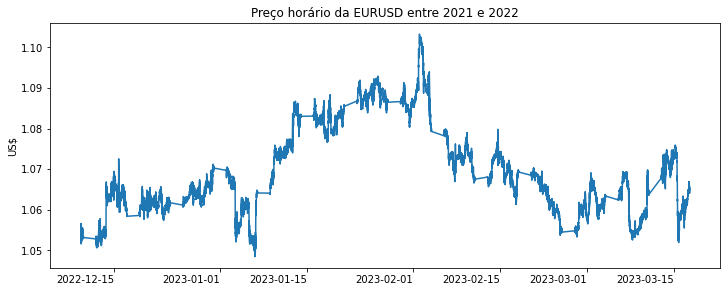

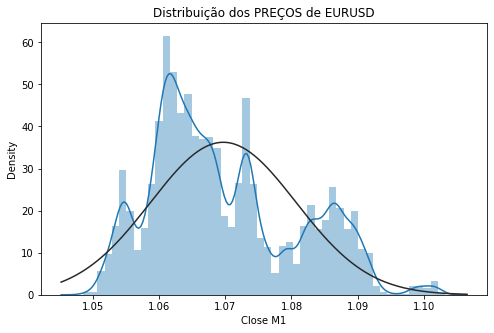

In [23]:
# plotando a variação de preço do ativo por hora
ax = df['Close'].plot(figsize=(12,5))
plt.title('Preço horário da EURUSD entre 2022 e 2023')
plt.xlabel('')
plt.ylabel('US$')
plt.tick_params(rotation = 0)
# plotando as distribuições dos preços, por DIA E HORA
plt.figure(figsize=(8,5))
ax = sns.distplot(df['Close'],
                  fit=norm,
                  kde=True)
ax.set_xlabel('Close M1')
ax.set_title('Distribuição dos PREÇOS de EURUSD')

In [14]:
df

Open     High      Low    Close  Volume
Time                                                        
2022-12-09 14:20  1.05579  1.05587  1.05570  1.05582     340
2022-12-09 14:21  1.05581  1.05588  1.05567  1.05567     273
2022-12-09 14:22  1.05568  1.05589  1.05566  1.05584     193
2022-12-09 14:23  1.05585  1.05588  1.05563  1.05565     326
2022-12-09 14:24  1.05564  1.05574  1.05541  1.05544     188
...                   ...      ...      ...      ...     ...
2023-03-17 11:55  1.06408  1.06416  1.06400  1.06406     394
2023-03-17 11:56  1.06406  1.06441  1.06403  1.06439     491
2023-03-17 11:57  1.06438  1.06461  1.06437  1.06457     314
2023-03-17 11:58  1.06457  1.06483  1.06457  1.06464     364
2023-03-17 11:59  1.06463  1.06477  1.06461  1.06467     492

[99999 rows x 5 columns]

### EDA (Análise exploratória de dados)

#### Avaliando dataset

In [26]:
# verificando informações gerais de AAPL
print('Dataset AAPL HORA\n')
print(df.info())

Dataset AAPL HORA

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 99999 entries, 2022-12-09 14:20:00+00:00 to 2023-03-17 11:59:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    99999 non-null  float64
 1   High    99999 non-null  float64
 2   Low     99999 non-null  float64
 3   Close   99999 non-null  float64
 4   Volume  99999 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 4.6 MB
None


#### Plot do dataset

In [ ]:
Para evitar dados errôneos devido a splits e distribuição de dividendos, vamos utilizar a feature Adj Close, que já considera essas questões

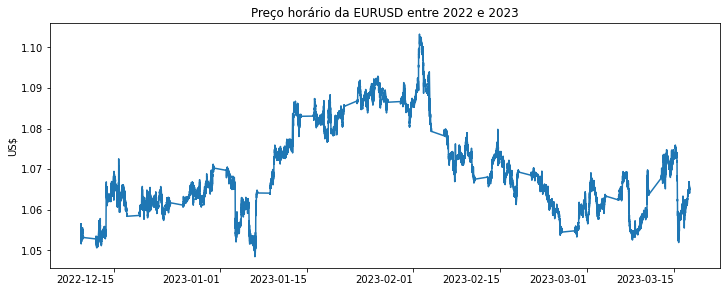

In [28]:
# plotando a variação de preço do ativo por hora
ax = df['Close'].plot(figsize=(12,5))
plt.title('Preço horário da EURUSD entre 2022 e 2023')
plt.xlabel('')
plt.ylabel('US$')
plt.tick_params(rotation = 0)

Text(0.5, 1.0, 'Distribuição dos PREÇOS de EURUSD HORA')

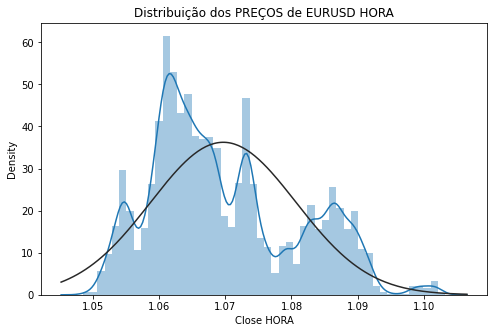

In [29]:
# plotando as distribuições dos preços, por DIA E HORA

plt.figure(figsize=(8,5))
ax = sns.distplot(df['Close'],
                   fit=norm,
                   kde=True)
ax.set_xlabel('Close HORA')
ax.set_title('Distribuição dos PREÇOS de EURUSD HORA')

### EDA para ARIMA

#### Sazonalidade

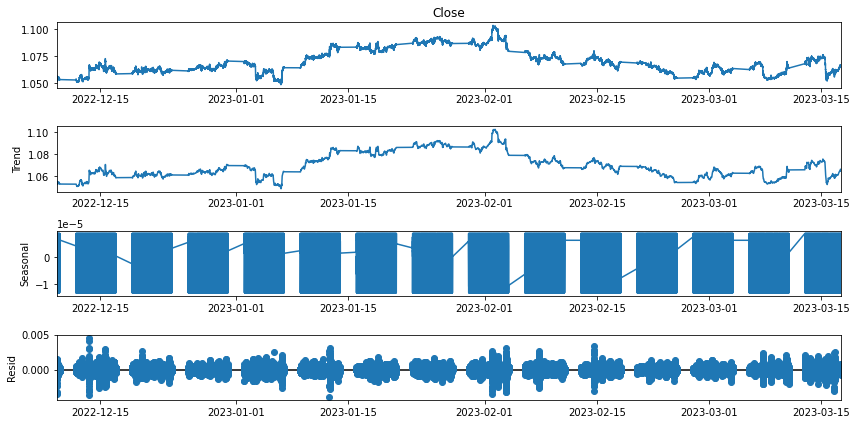

In [31]:
# fazendo a decomposição mensal
decomposicao_aapl = seasonal_decompose(df['Close'],
                                       model='additive', period = 40)
fig = decomposicao_aapl.plot()
fig.set_size_inches((12, 6))
# Tight layout to realign things
fig.tight_layout()
plt.show()

#### Série Estacionaria?

In [32]:
# rodando o método de Dickey Fuller

adfuller_aapl_hora = adfuller(df['Close'])
print('ADF Statistics AAPL HORA:', adfuller_aapl_hora[0])
print('p-value AAPL HORA:', adfuller_aapl_hora[1])

ADF Statistics AAPL HORA: -2.3813897386437204
p-value AAPL HORA: 0.14705805491946922


#### Diferenciação do dataset

In [33]:
# Calculo do retorno percentual (1º diferenciação)
df_arima = df.copy()
df_arima['return_percent'] = df_arima['Close'].pct_change()
df_arima.dropna(inplace=True)

Text(0.5, 1.0, 'Distribuição dos retornos (1º Diferenciação)')

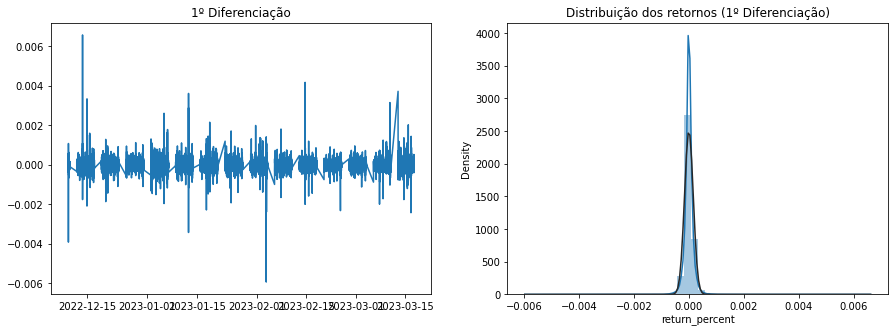

In [34]:
# verificando as distribuições dos retornos por HORA
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(df_arima['return_percent'])
axs[0].set_title('1º Diferenciação')

ax2 = sns.distplot(df_arima['return_percent'],
                   fit=norm,
                   kde=True,
                   ax=axs[1])
ax2.set_title('Distribuição dos retornos (1º Diferenciação)')

Text(0.5, 1.0, 'Distribuição da amostra comparado com teórico')

<Figure size 576x288 with 0 Axes>

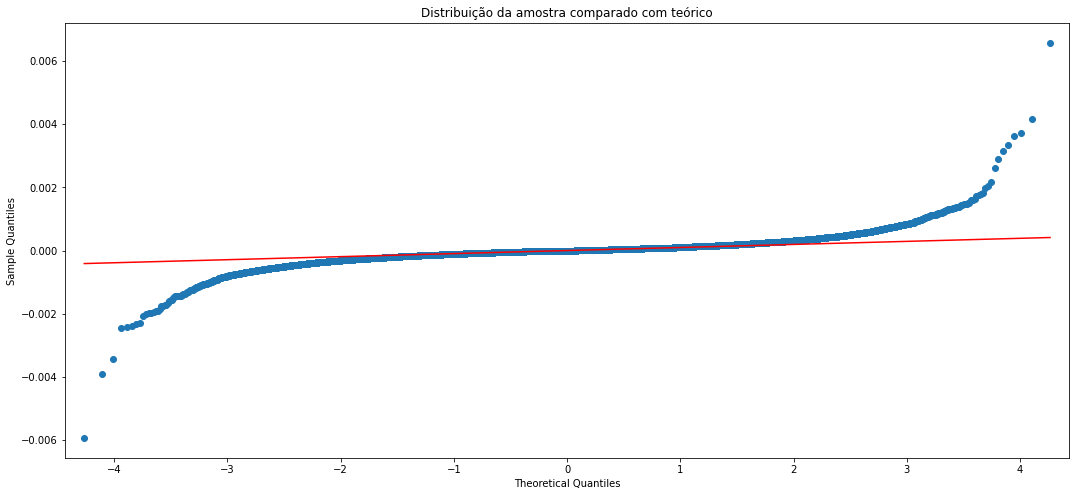

In [35]:
# comparando probabilidades de distribuições
# entre teórico e a amostra
plt.figure(figsize=(8,4))
qq1 = sm.qqplot(df_arima['return_percent'],
                line = 'q')
plt.title('Distribuição da amostra comparado com teórico')

In [36]:
# rodando o método de Dickey Fuller para retorno PERCENTUAL

adfuller_df_arima = adfuller(df_arima['return_percent'])
print('ADF Statistics AAPL HORA:', adfuller_df_arima[0])
print('p-value AAPL HORA:', adfuller_df_arima[1])

ADF Statistics AAPL HORA: -47.13799394901471
p-value AAPL HORA: 0.0


#### Teste Normalidade

In [59]:
# Para o DATASET de HORAS
# testando normalidade do retorno PERCENTUAL
print('Dataset HORAS, retorno PERCENTUAL (1º dif.):', stats.shapiro(df_arima['return_percent']))

Dataset HORAS, retorno PERCENTUAL (1º dif.): ShapiroResult(statistic=0.8322301506996155, pvalue=0.0)


#### PACF - Função de Autocorrelação Parcial (p)

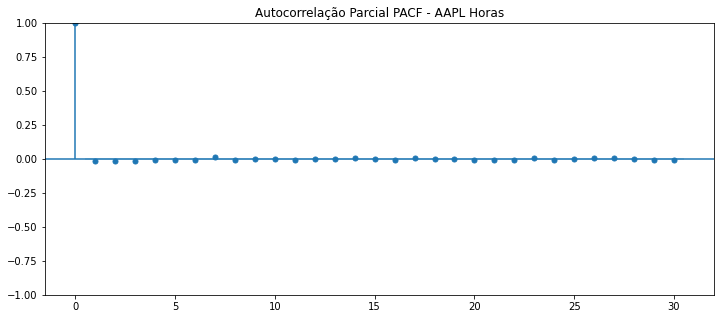

In [60]:
# plotando PACF para df HORAS
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(df_arima['return_percent'].dropna(), lags = 30, ax=ax)
ax.set_title('Autocorrelação Parcial PACF - AAPL Horas')
plt.show()

#### ACF - Função de Autocorrelação (q)


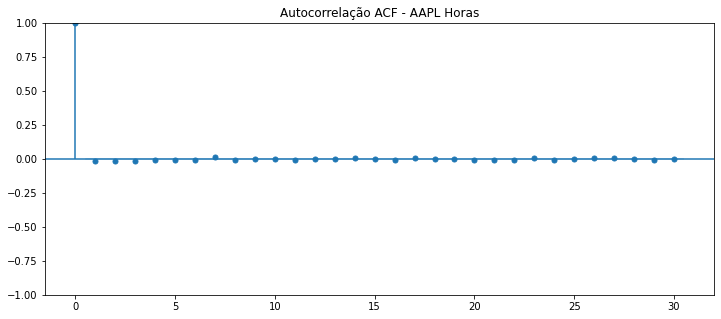

In [61]:
# plotando ACF para df HORAS
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(df_arima['return_percent'].dropna(), lags = 30, ax=ax)
ax.set_title('Autocorrelação ACF - AAPL Horas')
plt.show()

#### MODELO ARIMA

In [68]:
import statsmodels.api as sm

##### opcao 1

In [ ]:
%%time
# 27,1,27 ARIMA Model
#model = ARIMA(df['Close'], order=(16,1,16))
#model_fit = model.fit(disp=0)
modelo = sm.tsa.arima.ARIMA(df_arima['Close'], order=(16,1,16))
model_fit = modelo.fit()
print(model_fit.summary())

In [ ]:
# plot residuos
residuals = pd.DataFrame(model_fit.resid)

fig, (ax1, ax2) = plt.subplots( 1, 2, figsize = (16, 4))

ax1.plot(residuals)
sns.distplot(df['return_percent'],
                   fit=norm,
                   kde=True,
                   ax=ax2)

In [ ]:
# real vs previsto
fig, ax = plt.subplots(figsize=(12, 5))
model_fit.plot_predict(start = 1,
                       end = 500,
                       dynamic = False,
                       ax = ax)
plt.show()

##### opcao 2

In [ ]:
model = ARIMA(train_aapl_hora, order=(2,1,2))
model_fit = model.fit(disp=0)
# verificando os resultados
step = len(df)
# fc (forecast), se ()
fc, se, conf = model_fit.forecast(step)
fc = pd.Series(fc, index = test_aapl_hora[:step].index)
lower = pd.Series(conf[:,0], index = test_aapl_hora[:step].index)
upper = pd.Series(conf[:,1], index = test_aapl_hora[:step].index)
plt.figure(figsize=(16,8))
plt.plot(train_aapl_hora[1000:], label = 'treino', color='skyblue')
plt.plot(test_aapl_hora[:step], label = 'teste')
plt.plot(fc, label='previsto')
plt.fill_between(lower.index, lower, upper, color = 'k', alpha = 0.1)
plt.title('Previsto vs atual')
plt.legend(loc='best')

#### Média Móvel

In [37]:
# calculando média móvel do dataset HORAS (janela de 20 horas)
df_arima['media_movel'] = df_arima['Close'].rolling(20).mean()

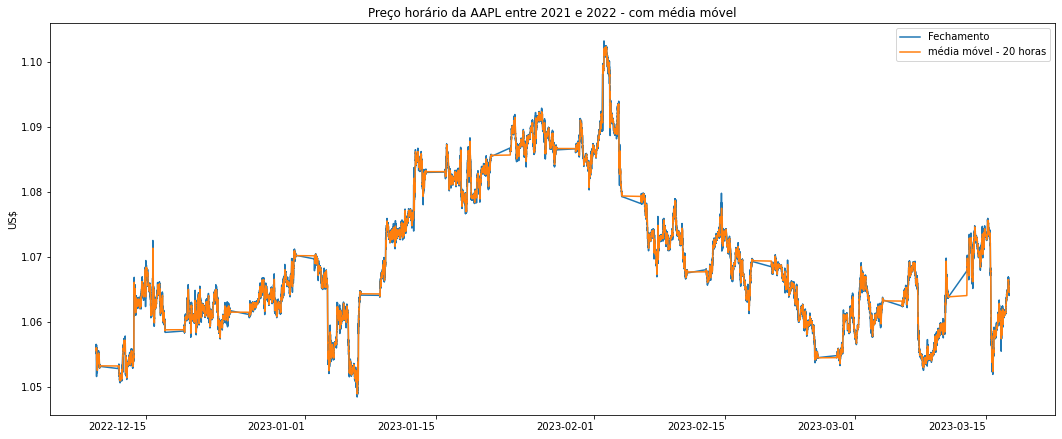

In [39]:
# plotando a variação de preço do ativo por hora
df_arima['Close'].plot(figsize=(18,8), label=('Fechamento'))
df_arima['media_movel'].plot(label=('média móvel - 20 horas'))
plt.title('Preço horário da AAPL entre 2022 e 2023 - com média móvel')
plt.xlabel('')
plt.ylabel('US$')
plt.tick_params(rotation = 0)
plt.legend()

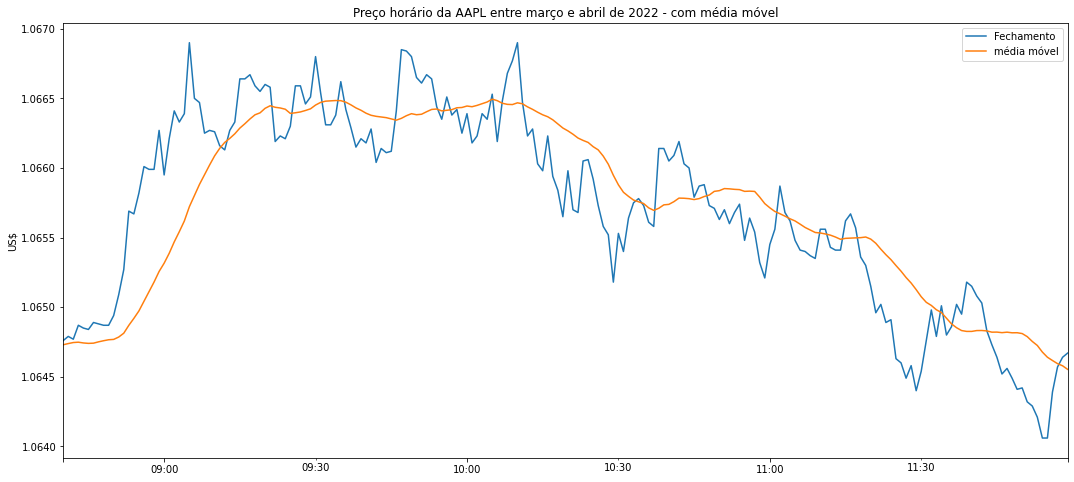

In [40]:
# plotando a variação de preço do ativo por hora - últimos 200 dados
df_arima['Close'][-200:].plot(figsize=(18,8), label=('Fechamento'))
df_arima['media_movel'][-200:].plot(label=('média móvel'))
plt.title('Preço horário da AAPL entre março e abril de 2022 - com média móvel')
plt.xlabel('')
plt.ylabel('US$')
plt.tick_params(rotation = 0)
plt.legend()

#### Identificando Outliers

In [41]:
# calculando desvio padrão móvel do dataset HORAS (janela de 20 horas)
df_arima['media_movel_d'] = df_arima['return_percent'].rolling(20).mean()
df_arima['std_movel_d'] = df_arima['return_percent'].rolling(20).std()

In [42]:

# identificando outliers

outliers_hora = []
upper_aapl = []
lower_aapl = []

# outliers no dataset de horas
for x, mm, sigma in list(zip(df_arima['return_percent'],df_arima['media_movel_d'],df_arima['std_movel_d'])):
  if (x > mm + 3*sigma) | (x < mm - 3*sigma):
    outliers_hora.append('outlier')
  else:
    outliers_hora.append('intlier')
  upper = mm + 3*sigma
  low = mm - 3*sigma
  upper_aapl.append(upper)
  lower_aapl.append(low)

df_arima['outliers'] = outliers_hora
df_arima['upper_limit'] = upper_aapl
df_arima['lower_limit'] = lower_aapl

In [43]:
# removendo dados nulos
df_arima.dropna(inplace=True)

Wall time: 65 ms


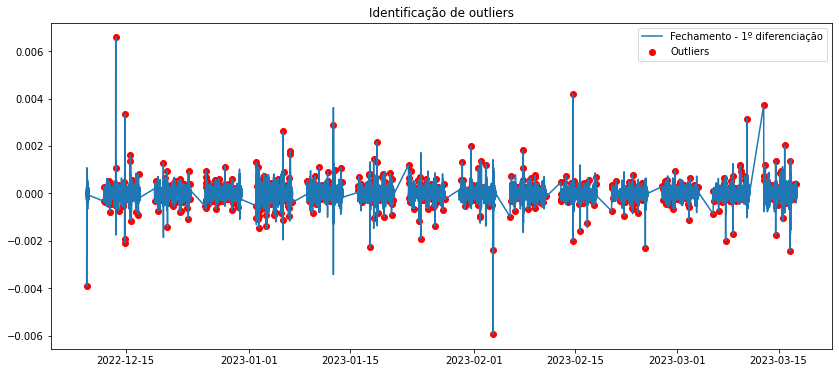

In [44]:
%%time

# plotando a variação de preço do ativo e os limites superior e inferior
fig, ax = plt.subplots(figsize=(14,6))

ax.plot(df_arima['return_percent'], label = 'Fechamento - 1º diferenciação')
z = df_arima[df_arima['outliers']=='outlier']
ax.scatter(z.index, z['return_percent'], color = 'red', label = 'Outliers')

ax.set_title('Identificação de outliers')
ax.legend()

In [45]:
print('Quantidade de outliers AAPL HORA:', (df_arima['outliers']=='outlier').sum())

Quantidade de outliers AAPL HORA: 564


#### Tratando outliers

In [46]:
df_arima['return_winso'] = stats.mstats.winsorize(df_arima['return_percent'],
                                                  limits=(0.01,0.01), axis=0)

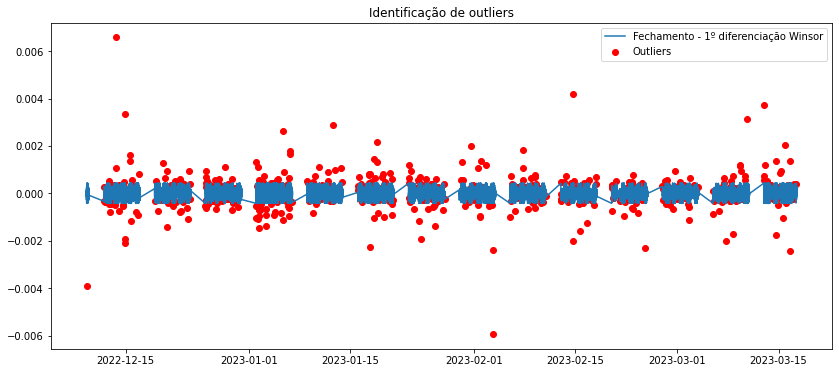

In [47]:
# plotando o return_winso
fig, ax = plt.subplots(figsize=(14,6))

ax.plot(df_arima['return_winso'], label = 'Fechamento - 1º diferenciação Winsor')
z = df_arima[df_arima['outliers']=='outlier']
ax.scatter(z.index, z['return_percent'], color = 'red', label = 'Outliers')

ax.set_title('Identificação de outliers')
ax.legend()

### EDA para Variáveis Exógenas

In [49]:
df_var_exog = df.copy()

#### Indicador RSI

In [52]:
RSI_PERIOD = 20 # definindo o período considerado para cálculo de RSI
df_var_exog['rsi'] = talib.RSI(df_var_exog['Close'], RSI_PERIOD)  # criando a feature RSI

# RSI < 30 -> 0 (comprar)
# RSI > 70 -> 1 (vender)
# Else -> 2 (nada)

df_var_exog['rsi_indicator'] = df_var_exog['rsi'].apply(lambda x: 0 if x<30 else 1 if x>70 else 2) 
display(df_var_exog[['Close','rsi','rsi_indicator']].tail(15))

Close        rsi  rsi_indicator
Time                                                        
2023-03-17 11:45:00+00:00  1.06464  41.394789              2
2023-03-17 11:46:00+00:00  1.06452  39.421194              2
2023-03-17 11:47:00+00:00  1.06456  40.417937              2
2023-03-17 11:48:00+00:00  1.06449  39.228933              2
2023-03-17 11:49:00+00:00  1.06441  37.888083              2
2023-03-17 11:50:00+00:00  1.06442  38.166173              2
2023-03-17 11:51:00+00:00  1.06432  36.448399              2
2023-03-17 11:52:00+00:00  1.06429  35.937618              2
2023-03-17 11:53:00+00:00  1.06421  34.577446              2
2023-03-17 11:54:00+00:00  1.06406  32.174035              2
2023-03-17 11:55:00+00:00  1.06406  32.174035              2
2023-03-17 11:56:00+00:00  1.06439  42.001225              2
2023-03-17 11:57:00+00:00  1.06457  46.455558              2
2023-03-17 11:58:00+00:00  1.06464  48.087620              2
2023-03-17 11:59:00+00:00  1.06467  48.791764              2

In [53]:
# verificando quantidade de valores encontrados
df_var_exog['rsi_indicator'].value_counts()

2    96625
1     1694
0     1680
Name: rsi_indicator, dtype: int64

Text(0.5, 1.0, 'Variação de RSI entre 2022 e 2023 - indicação da faixa de compra e venda')

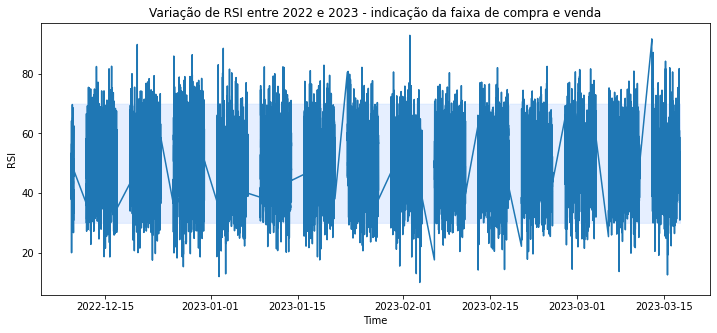

In [55]:
# plotando a variação de RSI
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_var_exog['rsi'].index, df_var_exog['rsi'], label='RSI')
ax.fill_between(df_var_exog['rsi'].index, y1=30, y2=70, color='#adccff', alpha=0.3)
ax.set_xlabel('Time')
ax.set_ylabel('RSI')
ax.set_title('Variação de RSI entre 2022 e 2023 - indicação da faixa de compra e venda')

#### Indicador de Bollinger Bands

In [56]:
# calculando a média móvel e limites superior e inferiror
# limites com base em 2 desvios padrão 
up, mid, low = BBANDS(df_var_exog['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

# criando features para a média e os limites
df_var_exog['upper'] = up
df_var_exog['mid'] = mid
df_var_exog['low'] = low
df_var_exog['bbp'] = (df_var_exog['Close'] - df_var_exog['low'])/(df_var_exog['upper'] - df_var_exog['low'])
df_var_exog.dropna(inplace=True)
     

Text(0.5, 1.0, 'Variação de do indicador de Bollinger - indicação da faixa de compra e venda')

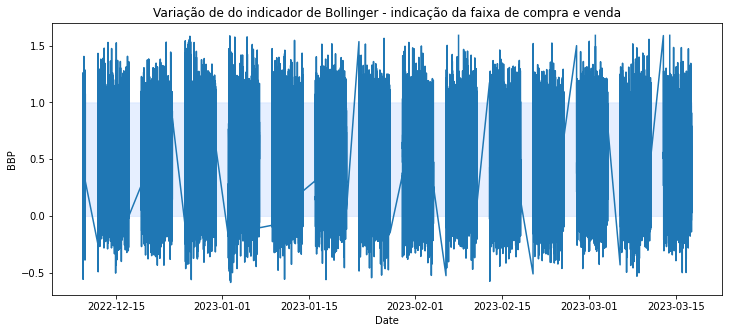

In [57]:
# plotando a variação de RSI
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_var_exog['bbp'].index, df_var_exog['bbp'], label='BBP (% Bollinger)')
ax.fill_between(df_var_exog['bbp'].index, y1=0, y2=1, color='#adccff', alpha=0.3)
ax.set_xlabel('Date')
ax.set_ylabel('BBP')
ax.set_title('Variação de do indicador de Bollinger - indicação da faixa de compra e venda')

In [58]:
# sinais de compra e venda
# segundo indicador de Bollinger
print('Sinal de venda:',(df_var_exog['bbp']>1).sum())
print('Sinal de compra:',(df_var_exog['bbp']<0).sum())

Sinal de venda: 5877
Sinal de compra: 5725


### Conclusões da EDA

### Suporte e resistência


In [72]:
# definindo a função de resistencia
def is_resistance(df,i):
  resistance = (df['High'][i] > df['High'][i-1]
                and df['High'][i] > df['High'][i+1]
                and df['High'][i+1] > df['High'][i+2]
                and df['High'][i-1] > df['High'][i-2])
  return resistance
# definindo a função de suporte
def is_support(df,i):
  support = (df['Low'][i] < df['Low'][i-1]
             and df['Low'][i] < df['Low'][i+1]
             and df['Low'][i+1] < df['Low'][i+2]
             and df['Low'][i-1] < df['Low'][i-2])
  return support
# resistência verdadeiro -> 1 (vender)
# suporte verdadeiro -> 0 (comprar)
# outros (2)
# criando feature com valores 2
df_var_exog['suport_resistencia'] = 2
# definindo os valores 1 e 0
for i in range(2, df_var_exog.shape[0] - 2):
  if is_resistance(df_var_exog,i):
    df_var_exog['suport_resistencia'][i] = 1 # definindo 1 para resistência
  elif is_support(df_var_exog,i):
    df_var_exog['suport_resistencia'][i] = 0 # definindo 0 para suporte
# contando os suportes e resistÊncias
df_var_exog.suport_resistencia.value_counts()

2    89463
1     5396
0     5120
Name: suport_resistencia, dtype: int64

### LTA e LTB

<AxesSubplot:xlabel='corr_class', ylabel='count'>

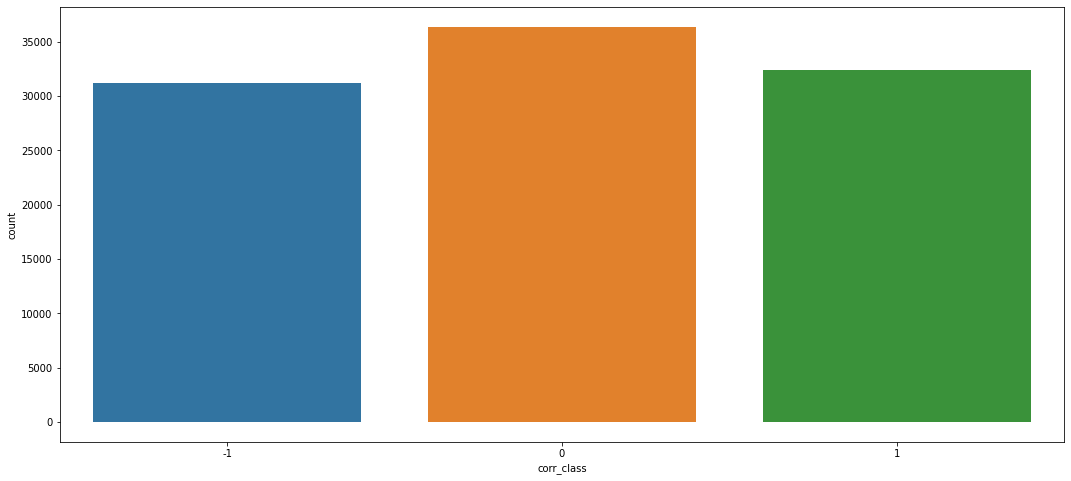

In [74]:
df_var_exog2 = df_var_exog.reset_index()
df_var_exog['corr'] = (df_var_exog2['Close'].rolling(20).corr(pd.Series(df_var_exog2.index))).tolist()
df_var_exog.dropna(inplace=True)
def condition(x):
    if x<=-0.5:
        return -1
    elif x>-0.5 and x<0.5:
        return 0
    else:
        return 1
df_var_exog['corr_class'] = df_var_exog['corr'].apply(condition)
# plotando os dois gráficos
sns.scatterplot(x = df_var_exog.index,y = df_var_exog['corr'])
sns.countplot(df_var_exog['corr_class'])

### Modelo Baseline — ARIMA

##### Divisão entre Treino e Teste 90:10

In [76]:
# dividindo em treino e teste, na proporção de 95:5
n = int(len(df)*0.95)
#n= 2263
train_aapl_hora = df['Close'][:n]
test_aapl_hora = df['Close'][n:]

print(len(train_aapl_hora))
print(len(test_aapl_hora))

94999
5000


In [80]:
model = sm.tsa.arima.ARIMA(train_aapl_hora, order=(2,1,2))
model_fit = model.fit()
# verificando os resultados
step = len(test_aapl_hora)
# fc (forecast), se ()
fc, se, conf = model_fit.forecast(step)
fc = pd.Series(fc, index = test_aapl_hora[:step].index)
lower = pd.Series(conf[:,0], index = test_aapl_hora[:step].index)
upper = pd.Series(conf[:,1], index = test_aapl_hora[:step].index)
plt.figure(figsize=(16,8))
plt.plot(train_aapl_hora[1000:], label = 'treino', color='skyblue')
plt.plot(test_aapl_hora[:step], label = 'teste')
plt.plot(fc, label='previsto')
plt.fill_between(lower.index, lower, upper, color = 'k', alpha = 0.1)
plt.title('Previsto vs atual')
plt.legend(loc='best')

ValueError: too many values to unpack (expected 3)

In [ ]:
model_fit.summary()

#### MODELO ARIMA - Step by step (sbs)

In [82]:

# dividindo em treino e teste, na proporção de 95:5
#n = int(len(df)*0.95)
n=200
train_aapl_hora_sbs = df['Close'][:n]
test_aapl_hora_sbs = df['Close'][n:]

In [84]:
%%time
tamanho_teste=len(test_aapl_hora_sbs)
fc_sbs = []

for i in range(tamanho_teste):
  # 2,1,2 ARIMA Model
  train_aapl_hora_sbs = df['Close'][:n+i]
  model_sbs = sm.tsa.arima.ARIMA(train_aapl_hora, order=(2,1,2))
  model_sbs_fit = model_sbs.fit()

  # forecast o próximo valor
  fc, se, conf = model_sbs_fit.forecast(1)
  # armazena na nossa lista
  fc_sbs.append(fc[0])

# transformando os valores previsto em uma série
# com o mesmo index da série de teste
forecast_sbs = pd.Series(fc_sbs, index = test_aapl_hora.index)

ValueError: not enough values to unpack (expected 3, got 1)

NameError: name 'forecast_sbs' is not defined

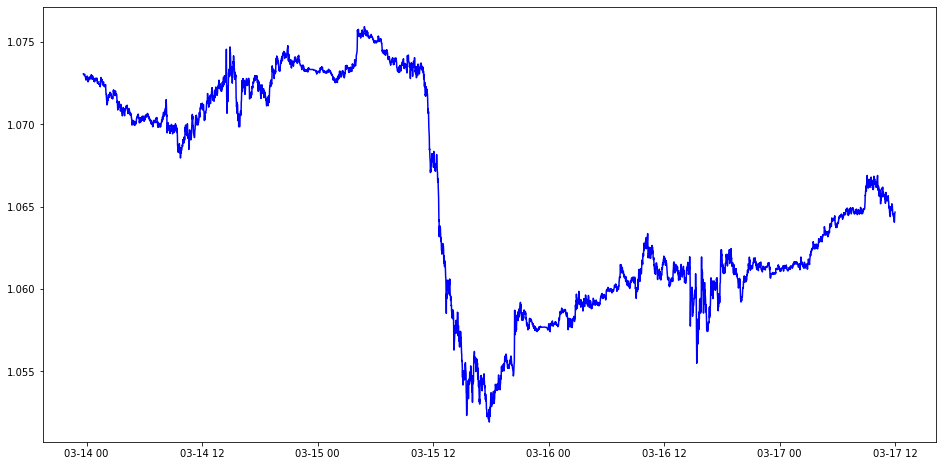

In [85]:
plt.figure(figsize=(16,8))
plt.plot(test_aapl_hora[:step], label = 'teste', color = 'blue')
plt.plot(forecast_sbs, label='previsto SBS', color = 'orange')
plt.title('Previsto vs Teste (step by step)')
plt.legend(loc='best')

### AUTO ARIMA

In [ ]:
auto_arima_aapl = auto_arima(df['Close'],
                             start_p=0, start_q=0,
                             max_p=5, max_q=5,
                             trace = True,
                             suppress_warnings = True)
auto_arima_aapl.summary()

##### outros modelos

In [ ]:
def constroi_features_defasadas(base,lista_features,defasagem_maxima):
    # Constrói features defasadas com base na base original
    # Copia a base
    base_cop = base.copy()
    for feat in lista_features:       
        for i in range(1,defasagem_maxima+1):
            base_cop[str(feat)+'_def_'+str(i)] = base_cop[feat].shift(i)
    return base_cop

In [ ]:
modelos_candidatos = {'Árvore':DecisionTreeRegressor(max_depth=5),
                      'RandomForest':RandomForestRegressor(max_depth=5),
                      'LGBM':LGBMRegressor(max_depth=5)
                     }
avaliacao = {}
for nome,model in modelos_candidatos.items():
    # Avalia a crossvalidação
    score = cross_val_score(model, # Escolhendo o nosso modelo da vez
                            X_train, y_train, # Nossos dados, excluindo o teste
                            cv=TimeSeriesSplit(n_splits=5), # Validação cruzada temporal
                            scoring='neg_mean_absolute_error', # Usando a métrica MAE
                           n_jobs=8 # Número de processadores, para ser mais rápido
                           ).mean() # Tirando a média de todos os folds
    avaliacao[nome] = -score # -score e não score para tornar o número positivo
#avaliacao
#{'LGBM': 2.432275552975372,  'RandomForest': 2.246902277238342,  'Árvore': 2.3692681121851775}

#### NOVO INSIGHT - CLASSIFICAÇÃO

In [90]:
def target(df):
# criando feature com 1h de defasagem (pegando a linha de cima)
  df['def_1'] = df['close'].shift(1)
  # criando feature comparando valor atual com o defasado
  df['subt'] = df['Close'] - df['def_1']
# criando a target de subida ou descida do valor da ação
  #0 -> caiu (com relação ao anterior)
  #1 -> subiu (com relação ao anterior)
  #2 -> igual ao anterior
  df['target'] = df['subt'].apply(lambda x: 0 if x<0 else 1 if x>0 else 2)
  return df

In [91]:
def preprocessamento(base, corte_treino_teste,target):
  # separando a base da target
  X = base.drop(target, axis=1)
  y = base[target]
  # cortando em treino e teste
  X_train = X[X.index<=corte_treino_teste]
  X_test = X[X.index>corte_treino_teste]
  y_train = y[y.index<=corte_treino_teste]
  y_test = y[y.index>corte_treino_teste]
  return X_train, X_test, y_train, y_test

##### Modelos Classificação

In [96]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [97]:
modelos_candidatos = {'Árvore':DecisionTreeClassifier(random_state=42),
                      'RandomForest':RandomForestClassifier(random_state=42),
                      'XGBoost':XGBClassifier(random_state=42)
                     }
def avaliacao_modelos(modelos,X_train,y_train):
  avaliacao = {}
  scores = []
  ts = TimeSeriesSplit(n_splits=5).split(X_train,y_train)
  for nome,model in modelos_candidatos.items():
      # Avalia a crossvalidação
    score = cross_val_score(model, # Escolhendo o nosso modelo da vez
                          X_train, y_train, # Nossos dados, excluindo o teste
                          cv=TimeSeriesSplit(n_splits=5).split(X_train,y_train), # Validação cruzada temporal
                          scoring='accuracy', # Usando a acurácia como métrica
                          ).mean() # Tirando a média de todos os folds
    avaliacao[nome] = score
    scores.append(score)
  
  return avaliacao, scores

#### Testando Modelo Campeão

In [98]:
base_cop = base.copy()
base_cop = constroi_features_futuras(base_cop,'target',1)
base_cop.drop('target', axis=1, inplace=True)
X1_train, X1_test, y1_train, y1_test = preprocessamento(base_cop, '2023-02-01', 'target_fut_1')
# criando df de resultados
result = pd.DataFrame()
# fitando o modelo
xgb = XGBClassifier(random_state=42,max_depth=5)
xgb.fit(X1_train, y1_train)
y1_pred = xgb.predict(X1_test)
y1_proba = xgb.predict_proba(X1_test)
y1_proba = y1_proba[:, 1]
# criando as colunas de resultados
result['y1_test'] = y1_test
result['y1_predict'] = y1_pred
result['proba'] = y1_proba
print(classification_report(y1_test, y1_pred))
# criando a matriz de confusão
ax = sns.heatmap(confusion_matrix(y1_test, y1_pred),
                 annot=True,
                 annot_kws={"fontsize":10},
                 fmt = 'd',
                 cmap = 'Blues')

NameError: name 'base' is not defined

#### Importância das features


In [99]:
feature_importance = xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X1_test.columns)[sorted_idx])
plt.title('Feature Importance')

NameError: name 'xgb' is not defined

#### Definindo tamanho do Treino


In [ ]:
X_train, X_test, y_train, y_test = preprocessamento(base_cop, '2022-03-15', 'target_fut_1')
accuracys = []
f1s = []
tempos = []
for pace in range(300, 1500, 50):
  print('teste com:',pace)
  X_tr = X_train[-pace:]
  y_tr = y_train[-pace:]
  X_t = X_test.copy()
  y_t = y_test
y_preds = []
  y_preds_proba = []
temp = []
for i in range(len(y_test)):
      # medindo o tempo de treinamento para cada pace
      start = time.time()
      # fitando o modelo
      xgb = XGBClassifier(random_state=42,max_depth=5)
      xgb.fit(X_tr, y_tr)
      y_pred = xgb.predict(X_t[:1])
      y_pred = y_pred[0]
      y_proba = xgb.predict_proba(X_t[:1])
      y_proba = y_proba[:, 1]
      end = time.time()
      temp.append((end-start))
y_preds.append(y_pred)
      y_preds_proba.append(y_proba)
X_tr = pd.concat([X_tr, X_t[:1]])
      X_tr = X_tr[1:]
      y_tr = y_tr.append(pd.Series(y_t[0]))
      y_tr = y_tr[1:]
X_t = X_t[1:]
      y_t = y_t[1:]
accuracys.append(accuracy_score(y_test, y_preds))
  f1s.append(f1_score(y_test, y_preds, average='weighted'))
  tempos.append(np.mean(temp))
df2 = pd.DataFrame({'accuracy': accuracys,
                   'f1_score': f1s,
                   'tempo(s)': tempos}, index=list(range(300, 1500, 50)))
df2

#### Otimização de Hiperparâmetros


In [ ]:
X_train, X_test, y_train, y_test = preprocessamento(base_cop, '2022-02-15', 'target_fut_1')
# otimização para XGBoost undersampled
xgb = XGBClassifier(random_state=42)
parametros_xgb = {
    'n_estimators': range(50,250,50),
    'max_depth': range(2,10,2),
    'gamma':[0.1, 0.5, 0.75]}
    
# Obtendo melhores parâmetros e melhor recall para XGBoost
grid_xgb = GridSearchCV(estimator = xgb,
                        param_grid = parametros_xgb,
                        cv=5,
                        scoring = 'f1_weighted')
grid_xgb.fit(X_train[-600:], y_train[-600:]) # somente a melhor qtd encontrada
xgb_over_best_params = grid_xgb.best_params_
xgb_over_best_score = grid_xgb.best_score_
print(grid_xgb.best_params_)
print(grid_xgb.best_score_)

#### Conclusões

#### Recomendações para continuidade do trabalho


# REGRESSÃO

In [31]:
# Calculando as bandas de bollinger

# Parametros iniciais
periodo = 20
desvios = 1.68

df["desvio"] = df["close"].rolling(periodo).std()
df["bbmm"] = df["close"].rolling(periodo).mean()
df["banda_sup"] = df["bbmm"] + (df["desvio"]*desvios)
df["banda_inf"] = df["bbmm"] - (df["desvio"]*desvios)


df['g_mean'] = df["close"].rolling(periodo).apply(lambda x: geometric_mean(x))
df['h_mean'] = df["close"].rolling(periodo).apply(lambda x: harmonic_mean(x))

In [32]:
#df.groupby(['from'])
#df.groupby(['from']).groups
#df.groupby(['from']).first()

#How about listing all elements of a particular group
#g = df.groupby(['country'])
#g.get_group('Brasil')

#group by column and apply aggregate
#df.groupby(['country'])['salary'].agg(np.sum)
#To calculate specific aggregate function on columns pass the dictionary of column names with aggregate functions
#df.groupby(['country'])['salary'].agg({'salary' : mean, 'age' : max})

#group by single columns and apply lambda expression
#df.groupby(by='country').agg({'salary' : lambda x : x.max()-x.min()})
#group by multiple column and apply aggregate
#df.groupby(by = ['country', 'state']).pipe({lambda x : x['salary'].sum()- x['rv'].sum())

In [33]:
df.groupby(['from'])['open'].mean()

from
2022-12-09 14:20    1.05579
2022-12-09 14:21    1.05581
2022-12-09 14:22    1.05568
2022-12-09 14:23    1.05585
2022-12-09 14:24    1.05564
                     ...   
2023-03-17 11:55    1.06408
2023-03-17 11:56    1.06406
2023-03-17 11:57    1.06438
2023-03-17 11:58    1.06457
2023-03-17 11:59    1.06463
Name: open, Length: 99999, dtype: float64

In [22]:
df2 = df.tail(100)

In [23]:
df2.h_mean.value_counts()

1.066371    1
1.065616    1
1.065371    1
1.065395    1
1.065421    1
           ..
1.065998    1
1.066009    1
1.066022    1
1.066032    1
1.064862    1
Name: h_mean, Length: 100, dtype: int64

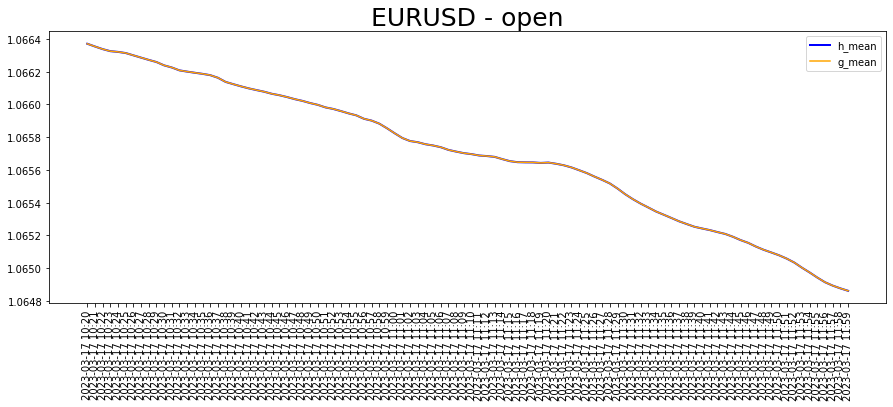

In [34]:
# Visualização MACD

plt.figure(figsize=(15,5))
plt.plot(df2['h_mean'], label = 'h_mean', color='blue', linewidth = 2)
plt.plot(df2['g_mean'], label = 'g_mean', color='orange')
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.title("EURUSD - open", fontsize = 25)
plt.show()

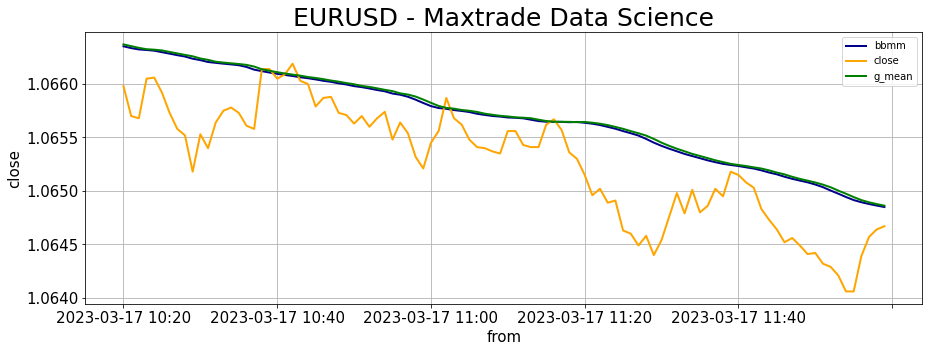

In [37]:
# Visualização - VWAP
# Inserindo um gráfico de teste

df2[["bbmm", "close",'g_mean']].plot(grid = True
                                                        , figsize = (15, 5)
                                                        , linewidth = 2
                                                        , fontsize = 15
                                                        , color = ["darkblue", "orange",'green'])
plt.xlabel("from"
           , fontsize = 15);
plt.ylabel("close"
           , fontsize = 15);
plt.title("EURUSD - Maxtrade Data Science"
           , fontsize = 25)
plt.legend();

In [36]:
df.tail()

time     open     high      low    close  \
time                                                                     
2023-03-17 11:55  2023-03-17 11:55  1.06408  1.06416  1.06400  1.06406   
2023-03-17 11:56  2023-03-17 11:56  1.06406  1.06441  1.06403  1.06439   
2023-03-17 11:57  2023-03-17 11:57  1.06438  1.06461  1.06437  1.06457   
2023-03-17 11:58  2023-03-17 11:58  1.06457  1.06483  1.06457  1.06464   
2023-03-17 11:59  2023-03-17 11:59  1.06463  1.06477  1.06461  1.06467   

                  volume              from    desvio      bbmm  banda_sup  \
time                                                                        
2023-03-17 11:55     394  2023-03-17 11:55  0.000360  1.064640   1.065245   
2023-03-17 11:56     491  2023-03-17 11:56  0.000360  1.064617   1.065222   
2023-03-17 11:57     314  2023-03-17 11:57  0.000347  1.064595   1.065178   
2023-03-17 11:58     364  2023-03-17 11:58  0.000337  1.064579   1.065146   
2023-03-17 11:59     492  2023-03-17 11:59  0.000307  1.064554   1.065070   

                  banda_inf    g_mean    h_mean  
time                                             
2023-03-17 11:55   1.064036  1.064640  1.064640  
2023-03-17 11:56   1.064012  1.064617  1.064617  
2023-03-17 11:57   1.064011  1.064594  1.064594  
2023-03-17 11:58   1.064012  1.064579  1.064579  
2023-03-17 11:59   1.064037  1.064553  1.064553

In [38]:
df['Returns'] = df['close'].pct_change()

In [39]:
df['Adj Close'] = df['close'].shift(-1)

In [40]:
df.dropna(inplace=True)

In [41]:
qtd_linhas = len(df)

qtd_linhas_treino= round(.50 * qtd_linhas)
qtd_linhas_teste= 300 
qtd_linhas_validacao = qtd_linhas -1

info = (
    f"linhas treino= 0:{qtd_linhas_treino}"
    f" linhas teste= {qtd_linhas_treino}:{qtd_linhas_treino + qtd_linhas_teste -1}"
    f" linhas validação= {qtd_linhas_validacao}"
)

info

'linhas treino= 0:49990 linhas teste= 49990:50289 linhas validação= 99978'

In [42]:
df["data_pregao"] = df.index

In [67]:
#reindexando o data frame
df = df.reset_index(drop=True)

In [68]:
df_completo = df

In [69]:
df_completo.columns

Index(['real', 'previsao'], dtype='object')

In [ ]:
#separando as features e labels
features = df.drop(['time','close', 'data_pregao', 'desvio', 'from'], 1)
labels = df['Adj Close']

In [51]:
features

open     high      low  volume      bbmm  banda_sup  banda_inf  \
0      1.05601  1.05614  1.05599     279  1.055988   1.056447   1.055530   
1      1.05610  1.05610  1.05592     241  1.055997   1.056450   1.055543   
2      1.05599  1.05605  1.05594      81  1.056015   1.056449   1.055580   
3      1.05603  1.05603  1.05579     376  1.056012   1.056450   1.055574   
4      1.05581  1.05585  1.05563     435  1.056016   1.056445   1.055587   
...        ...      ...      ...     ...       ...        ...        ...   
99974  1.06422  1.06425  1.06404     521  1.064677   1.065239   1.064116   
99975  1.06408  1.06416  1.06400     394  1.064640   1.065245   1.064036   
99976  1.06406  1.06441  1.06403     491  1.064617   1.065222   1.064012   
99977  1.06438  1.06461  1.06437     314  1.064595   1.065178   1.064011   
99978  1.06457  1.06483  1.06457     364  1.064579   1.065146   1.064012   

         g_mean  
0      1.055988  
1      1.055996  
2      1.056014  
3      1.056012  
4      1.056016  
...         ...  
99974  1.064677  
99975  1.064640  
99976  1.064617  
99977  1.064594  
99978  1.064579  

[99979 rows x 8 columns]

In [52]:
#Agora vamos escolher as melhores variaveis para da nossa base de dados com Kbest

from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
##################################################################################

features_list = ('open','high','low','volume', 'Returns')

k_best_features = SelectKBest(k='all')
k_best_features.fit_transform(features, labels)
k_best_features_scores = k_best_features.scores_
raw_pairs = zip(features_list[1:], k_best_features_scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()
print ('')
print ("Melhores features:")
print (k_best_features_final)


Melhores features:
{'low': 58075.352666261395, 'volume': 57753.39313666694, 'high': 44986.654655234, 'Returns': 2.3667147763102747}


In [53]:
#Separa os dados de treino teste e validação
X_train = features[:qtd_linhas_treino]
X_test = features[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

y_train = labels[:qtd_linhas_treino]
y_test = labels[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

print( len(X_train), len(y_train))

print( len(X_test), len(y_test))

49990 49990
299 299


In [54]:
# Normalizando os dados de entrada(features)

# Gerando o novo padrão
scaler = StandardScaler() # MinMaxScaler() 94.37
X_train_scale = scaler.fit_transform(X_train)  # Normalizando os dados de entrada(treinamento)
X_test_scale  = scaler.transform(X_test)       # Normalizando os dados de entrada(teste)

In [55]:
#treinamento usando regressão linear
lr = linear_model.LinearRegression()
lr.fit(X_train_scale, y_train)
pred= lr.predict(X_test_scale)
cd =r2_score(y_test, pred)

f'Coeficiente de determinação (R2):{cd * 100:.2f}'

'Coeficiente de determinação (R2):94.06'

In [56]:
valor_novo = features.tail(58)
valor_novo

open     high      low  volume      bbmm  banda_sup  banda_inf  \
99921  1.06544  1.06561  1.06531     524  1.065687   1.066086   1.065289   
99922  1.06554  1.06587  1.06551     496  1.065672   1.066025   1.065318   
99923  1.06587  1.06598  1.06568     429  1.065654   1.065978   1.065330   
99924  1.06567  1.06583  1.06554     166  1.065635   1.065929   1.065341   
99925  1.06564  1.06574  1.06540     233  1.065619   1.065912   1.065327   
99926  1.06548  1.06552  1.06540     295  1.065597   1.065882   1.065311   
99927  1.06541  1.06555  1.06530     381  1.065573   1.065844   1.065301   
99928  1.06541  1.06547  1.06532     270  1.065554   1.065828   1.065281   
99929  1.06537  1.06544  1.06534     378  1.065536   1.065813   1.065260   
99930  1.06534  1.06560  1.06528     326  1.065533   1.065808   1.065258   
99931  1.06555  1.06563  1.06554     257  1.065526   1.065793   1.065259   
99932  1.06557  1.06557  1.06543     564  1.065517   1.065785   1.065250   
99933  1.06544  1.06547  1.06540     479  1.065504   1.065766   1.065242   
99934  1.06541  1.06552  1.06525     454  1.065487   1.065735   1.065240   
99935  1.06541  1.06563  1.06536     449  1.065495   1.065746   1.065243   
99936  1.06561  1.06577  1.06561     341  1.065496   1.065751   1.065241   
99937  1.06567  1.06580  1.06555     323  1.065497   1.065753   1.065242   
99938  1.06556  1.06556  1.06531     254  1.065500   1.065752   1.065247   
99939  1.06535  1.06537  1.06528     121  1.065504   1.065743   1.065265   
99940  1.06531  1.06538  1.06514     230  1.065489   1.065762   1.065216   
99941  1.06515  1.06515  1.06492     243  1.065459   1.065795   1.065123   
99942  1.06494  1.06507  1.06490     331  1.065416   1.065749   1.065084   
99943  1.06499  1.06504  1.06489     339  1.065377   1.065747   1.065007   
99944  1.06492  1.06493  1.06479     344  1.065342   1.065738   1.064945   
99945  1.06490  1.06494  1.06463     376  1.065299   1.065772   1.064826   
99946  1.06467  1.06470  1.06459     302  1.065259   1.065797   1.064720   
99947  1.06461  1.06466  1.06428     468  1.065213   1.065820   1.064606   
99948  1.06449  1.06467  1.06449     165  1.065173   1.065821   1.064526   
99949  1.06459  1.06459  1.06439     308  1.065126   1.065831   1.064421   
99950  1.06440  1.06462  1.06434     330  1.065075   1.065791   1.064359   
99951  1.06455  1.06485  1.06453     259  1.065035   1.065733   1.064337   
99952  1.06476  1.06505  1.06475     294  1.065013   1.065693   1.064332   
99953  1.06499  1.06499  1.06475     402  1.064982   1.065648   1.064315   
99954  1.06480  1.06501  1.06475     442  1.064962   1.065606   1.064317   
99955  1.06500  1.06501  1.06479     328  1.064920   1.065512   1.064329   
99956  1.06480  1.06489  1.06476     353  1.064880   1.065392   1.064368   
99957  1.06487  1.06513  1.06485     320  1.064852   1.065291   1.064414   
99958  1.06501  1.06507  1.06494     341  1.064832   1.065225   1.064439   
99959  1.06494  1.06518  1.06491     218  1.064826   1.065200   1.064452   
99960  1.06517  1.06532  1.06505     307  1.064826   1.065200   1.064452   
99961  1.06514  1.06522  1.06501     292  1.064832   1.065215   1.064449   
99962  1.06509  1.06509  1.06488     414  1.064833   1.065216   1.064449   
99963  1.06503  1.06511  1.06482     202  1.064830   1.065213   1.064446   
99964  1.06482  1.06487  1.06467     318  1.064820   1.065204   1.064437   
99965  1.06472  1.06473  1.06459     256  1.064821   1.065204   1.064438   
99966  1.06463  1.06465  1.06452     175  1.064817   1.065208   1.064426   
99967  1.06452  1.06465  1.06451     202  1.064821   1.065203   1.064438   
99968  1.06454  1.06462  1.06441     246  1.064816   1.065208   1.064424   
99969  1.06449  1.06452  1.06435     303  1.064817   1.065207   1.064426   
99970  1.06439  1.06450  1.06430     381  1.064811   1.065216   1.064405   
99971  1.06442  1.06447  1.06426     306  1.064789   1.065234   1.064343   
99972  1.06432  1.06432  1.06414     337  1.064754   1.065

In [57]:
#executando a previsão
previsao=scaler.transform(valor_novo)
pred=lr.predict(previsao)

pred

array([1.06547949, 1.06577623, 1.06580348, 1.06568982, 1.0655294 ,
       1.06545404, 1.06543915, 1.06539189, 1.06540873, 1.06549948,
       1.06560512, 1.0654662 , 1.06543937, 1.06537618, 1.06554607,
       1.06573265, 1.06567389, 1.06536525, 1.06531562, 1.06523711,
       1.06498001, 1.06502367, 1.0649632 , 1.06484009, 1.06473234,
       1.06464739, 1.064409  , 1.06464403, 1.06444835, 1.06453933,
       1.0647753 , 1.06497981, 1.06480373, 1.06492756, 1.06484217,
       1.06484145, 1.06505366, 1.06499885, 1.06509701, 1.06518314,
       1.0650928 , 1.06492249, 1.06492166, 1.06474312, 1.06463024,
       1.06456459, 1.06462013, 1.06450794, 1.06441436, 1.06441794,
       1.06434462, 1.06419298, 1.0641473 , 1.06411861, 1.06409569,
       1.06432134, 1.06455402, 1.0647699 ])

In [58]:
data_pregao_full=df_completo['data_pregao']
data_pregao=data_pregao_full.tail(58)

res_full=df_completo['Adj Close']
res=res_full.tail(58)

df=pd.DataFrame({'data_pregao':data_pregao, 'real':res, 'previsao':pred})


df.set_index('data_pregao', inplace=True)

df.head()

real  previsao
data_pregao                        
2023-03-17 11:01  1.06587  1.065479
2023-03-17 11:02  1.06568  1.065776
2023-03-17 11:03  1.06562  1.065803
2023-03-17 11:04  1.06548  1.065690
2023-03-17 11:05  1.06541  1.065529

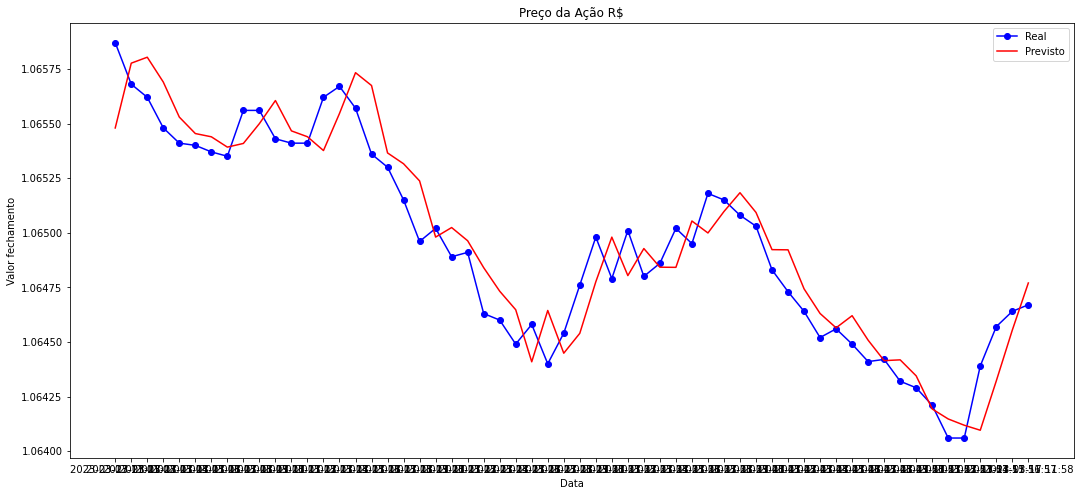

In [59]:
#plotagem
plt.title("Preço da Ação R$")
plt.plot(df["real"],label = "Real", color = "blue", marker = 'o')
plt.plot(df["previsao"],label = "Previsto", color = "red")
plt.xlabel("Data")
plt.ylabel("Valor fechamento")
plt.legend()

In [102]:
for index, row in df.iterrows():
    df.loc[index,'diferenca'] = (df.loc[index,'real'] - df.loc[index,'previsao']);

In [103]:
df.tail()

real  previsao  diferenca
data_pregao                                   
2023-03-17 11:54  1.06406  1.064108  -0.000048
2023-03-17 11:55  1.06439  1.064083   0.000307
2023-03-17 11:56  1.06457  1.064309   0.000261
2023-03-17 11:57  1.06464  1.064551   0.000089
2023-03-17 11:58  1.06467  1.064772  -0.000102

In [ ]:
intervalo_superior = dados['close'].mean() + dados['close'].std() 
intervalo_inferior = dados['close'].mean() - dados['close'].std() 

#### OUTROS MODELOS

In [104]:
# importar o modelo Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

In [105]:
lr.fit(X_train_scale, y_train)
pred= lr.predict(X_test_scale)

In [106]:
# treinando o modelo 
regression = RandomForestRegressor(n_estimators= 150, random_state=42).fit(X_train_scale, y_train); #n_estimators= 10, random_state=42
pred = regression.predict(X_test_scale)
cd_RL =r2_score(y_test, pred)

f'Coeficiente de determinação (R2):{cd_RL * 100:.2f}'

'Coeficiente de determinação (R2):93.32'

In [107]:
valor_novo = features.tail(58)
valor_novo

open     high      low  volume
99939  1.06544  1.06561  1.06531     524
99940  1.06554  1.06587  1.06551     496
99941  1.06587  1.06598  1.06568     429
99942  1.06567  1.06583  1.06554     166
99943  1.06564  1.06574  1.06540     233
99944  1.06548  1.06552  1.06540     295
99945  1.06541  1.06555  1.06530     381
99946  1.06541  1.06547  1.06532     270
99947  1.06537  1.06544  1.06534     378
99948  1.06534  1.06560  1.06528     326
99949  1.06555  1.06563  1.06554     257
99950  1.06557  1.06557  1.06543     564
99951  1.06544  1.06547  1.06540     479
99952  1.06541  1.06552  1.06525     454
99953  1.06541  1.06563  1.06536     449
99954  1.06561  1.06577  1.06561     341
99955  1.06567  1.06580  1.06555     323
99956  1.06556  1.06556  1.06531     254
99957  1.06535  1.06537  1.06528     121
99958  1.06531  1.06538  1.06514     230
99959  1.06515  1.06515  1.06492     243
99960  1.06494  1.06507  1.06490     331
99961  1.06499  1.06504  1.06489     339
99962  1.06492  1.06493  1.06479     344
99963  1.06490  1.06494  1.06463     376
99964  1.06467  1.06470  1.06459     302
99965  1.06461  1.06466  1.06428     468
99966  1.06449  1.06467  1.06449     165
99967  1.06459  1.06459  1.06439     308
99968  1.06440  1.06462  1.06434     330
99969  1.06455  1.06485  1.06453     259
99970  1.06476  1.06505  1.06475     294
99971  1.06499  1.06499  1.06475     402
99972  1.06480  1.06501  1.06475     442
99973  1.06500  1.06501  1.06479     328
99974  1.06480  1.06489  1.06476     353
99975  1.06487  1.06513  1.06485     320
99976  1.06501  1.06507  1.06494     341
99977  1.06494  1.06518  1.06491     218
99978  1.06517  1.06532  1.06505     307
99979  1.06514  1.06522  1.06501     292
99980  1.06509  1.06509  1.06488     414
99981  1.06503  1.06511  1.06482     202
99982  1.06482  1.06487  1.06467     318
99983  1.06472  1.06473  1.06459     256
99984  1.06463  1.06465  1.06452     175
99985  1.06452  1.06465  1.06451     202
99986  1.06454  1.06462  1.06441     246
99987  1.06449  1.06452  1.06435     303
99988  1.06439  1.06450  1.06430     381
99989  1.06442  1.06447  1.06426     306
99990  1.06432  1.06432  1.06414     337
99991  1.06429  1.06432  1.06406     403
99992  1.06422  1.06425  1.06404     521
99993  1.06408  1.06416  1.06400     394
99994  1.06406  1.06441  1.06403     491
99995  1.06438  1.06461  1.06437     314
99996  1.06457  1.06483  1.06457     364

In [108]:
#executando a previsão
previsao=scaler.transform(valor_novo)
pred=regression.predict(previsao)

pred

array([1.06558127, 1.06573987, 1.06580173, 1.06573533, 1.06555527,
       1.06543967, 1.06551753, 1.06541287, 1.06545913, 1.0655892 ,
       1.06563433, 1.0655538 , 1.06543353, 1.06538367, 1.06559207,
       1.06562573, 1.06562447, 1.0653068 , 1.06536   , 1.0652426 ,
       1.06494007, 1.065091  , 1.06499867, 1.0647972 , 1.0645884 ,
       1.06474033, 1.0644228 , 1.06469867, 1.0644676 , 1.06454053,
       1.0647418 , 1.065024  , 1.06482427, 1.06494247, 1.0648624 ,
       1.0648766 , 1.0649858 , 1.06492787, 1.06514207, 1.06512153,
       1.06517727, 1.06490053, 1.06492727, 1.06473813, 1.0646414 ,
       1.064611  , 1.06460807, 1.06454593, 1.064455  , 1.06434067,
       1.06441493, 1.06420127, 1.0640824 , 1.06418993, 1.06405407,
       1.06422513, 1.0644676 , 1.06470767])

In [109]:
data_pregao_full=df_completo['data_pregao']
data_pregao=data_pregao_full.tail(58)

res_full=df_completo['Adj Close']
res=res_full.tail(58)

df=pd.DataFrame({'data_pregao':data_pregao, 'real':res, 'previsao':pred})


df.set_index('data_pregao', inplace=True)

df.head()

real  previsao
data_pregao                        
2023-03-17 11:01  1.06587  1.065581
2023-03-17 11:02  1.06568  1.065740
2023-03-17 11:03  1.06562  1.065802
2023-03-17 11:04  1.06548  1.065735
2023-03-17 11:05  1.06541  1.065555

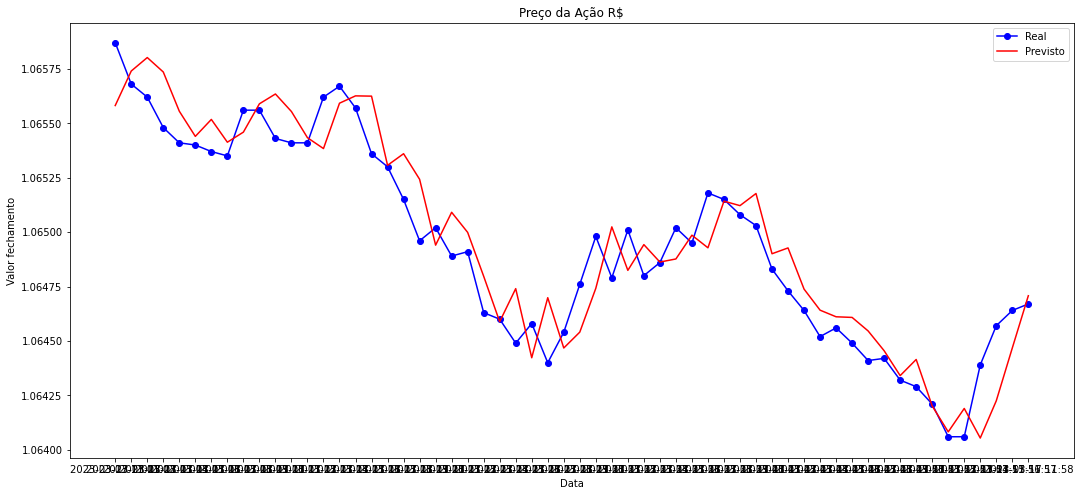

In [110]:
#plotagem
plt.title("Preço da Ação R$")
plt.plot(df["real"],label = "Real", color = "blue", marker = 'o')
plt.plot(df["previsao"],label = "Previsto", color = "red")
plt.xlabel("Data")
plt.ylabel("Valor fechamento")
plt.legend()

In [111]:
for index, row in df.iterrows():
    df.loc[index,'diferenca'] = (df.loc[index,'real'] - df.loc[index,'previsao']);

In [112]:
df.tail()

real  previsao  diferenca
data_pregao                                   
2023-03-17 11:54  1.06406  1.064190  -0.000130
2023-03-17 11:55  1.06439  1.064054   0.000336
2023-03-17 11:56  1.06457  1.064225   0.000345
2023-03-17 11:57  1.06464  1.064468   0.000172
2023-03-17 11:58  1.06467  1.064708  -0.000038